## Image Recognition using Convolutional Neural Network

### Let us start by importing basic modules:

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import keras
import pandas as pd
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

### Next, let us import the label file and view any random image along with its label:

automobile


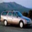

In [10]:
labels = pd.read_csv('cifar10Labels.csv', index_col=0)
# View an image
img_idx = 5
print(labels.label[img_idx])
Image.open('cifar10/'+str(img_idx)+'.png')

### Now, let us split the data into training and test, follow up with its transformation and normalization:

In [11]:
# Splitting data into Train and Test data
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(labels.label, test_size=0.3, random_state=42)
train_idx, test_idx = y_train.index, y_test.index # Stroing indexes for later use
# Reading images for training 
temp = []
for img_idx in y_train.index:
    img_path = os.path.join('cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)    
X_train = np.stack(temp)
# Reading images for testing 
temp = []
for img_idx in y_test.index:
    img_path = os.path.join('cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)
X_test = np.stack(temp)
# Normalizing image data
X_train = X_train/255.
X_test = X_test/255.

### The next preprocessing step it to label encode the image respective labels:

In [12]:
# One-hot encoding 10 output classes
encode_X = LabelEncoder()
encode_X_fit = encode_X.fit_transform(y_train)
y_train = keras.utils.to_categorical(encode_X_fit)

### Now, let us define the CNN network:

In [13]:
# Defining CNN network
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])

2025-06-24 08:05:22.978725: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Summary of the above network:

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (Flatten)                  │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred_layer (Dense)              │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,746 (237.29 KB)

 Trainable params: 60,554 (236.54 KB)

 Non-trainable params: 192 (768.00 B)

### Let us now compile and train the model for just five epochs:

In [15]:
# Compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint.keras' # Weights to be stored in Keras format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])

Epoch 1/5


2025-06-24 08:05:24.656796: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 344064000 exceeds 10% of free system memory.


875/875 ━━━━━━━━━━━━━━━━━━━━ 86s 90ms/step - accuracy: 0.4157 - loss: 1.9997 - val_accuracy: 0.3940 - val_loss: 2.2657
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.6082 - loss: 1.2152 - val_accuracy: 0.3954 - val_loss: 2.4036
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.6705 - loss: 1.0103 - val_accuracy: 0.5660 - val_loss: 1.4486
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.7047 - loss: 0.9019 - val_accuracy: 0.5674 - val_loss: 1.4118
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.7267 - loss: 0.8265 - val_accuracy: 0.5886 - val_loss: 1.3748


### Now, with the given model, let us now perform prediction:

In [16]:
# << DeprecationWarning: The truth value of an empty array is ambiguous >> can arise due to a NumPy version higher than 1.13.3.
# The issue will be updated in upcoming version.
pred_probs = model.predict(X_test[:10])
pred = encode_X.inverse_transform(np.argmax(pred_probs, axis=1))
act = y_test[:10].values
res = pd.DataFrame({'predicted': pred, 'actual': act})
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


,predicted,actual
0,truck,horse
1,ship,ship
2,airplane,airplane
3,bird,frog
4,dog,automobile
5,horse,frog
6,ship,ship
7,truck,airplane
8,cat,frog
9,dog,dog


### We can further proceed with train and test accuracy along with the confusion matrix to judge which class the model is predicting better:

In [17]:
from mlxtend.evaluate import scoring
train_pred = np.argmax(model.predict(X_train), axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
train_acc = scoring(encode_X.inverse_transform(train_pred),
                   encode_X.inverse_transform([np.argmax(x) for x in y_train]))
test_acc = scoring(encode_X.inverse_transform(test_pred), y_test)
print('Train accuracy: ', np.round(train_acc, 5))
print('Test accuracy: ', np.round(test_acc, 5))

   1/1094 ━━━━━━━━━━━━━━━━━━━━ 2:57 163ms/step

2025-06-24 08:11:00.102567: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 430080000 exceeds 10% of free system memory.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
Train accuracy:  0.34369
Test accuracy:  0.39953


   7/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step

2025-06-24 08:11:28.340796: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 430080000 exceeds 10% of free system memory.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step


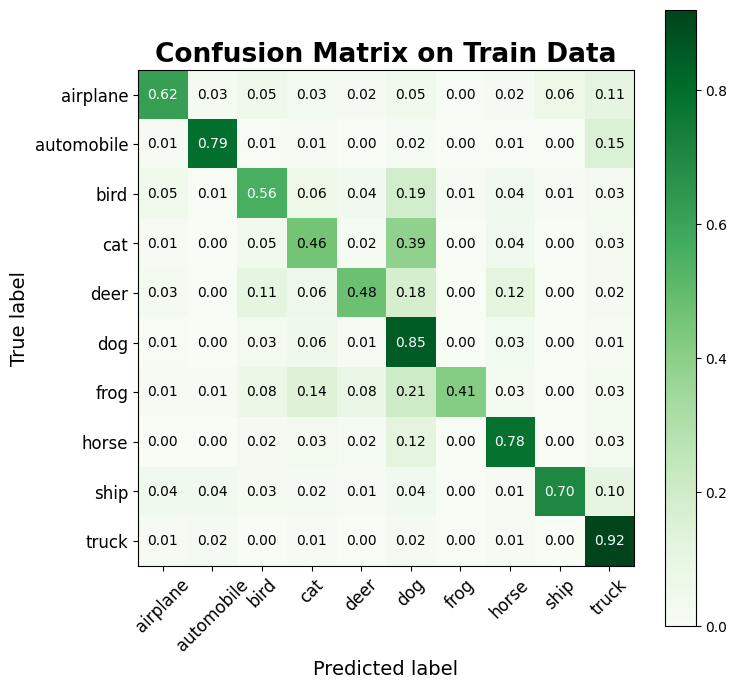

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


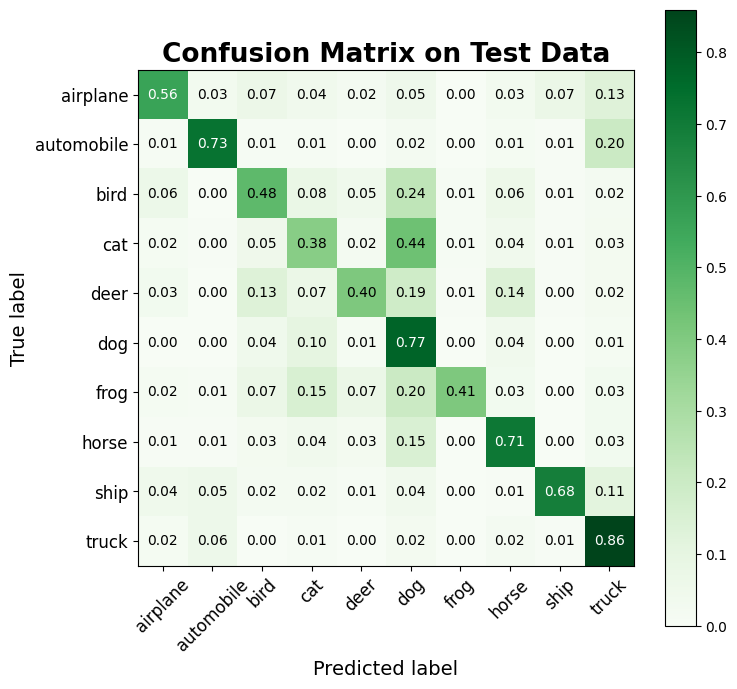

In [18]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
def plot_cm(cm, text):    
    class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_confusion_matrix(conf_mat=cm, 
                          colorbar=True, figsize=(8, 8), cmap='Greens',
                          show_absolute=False, show_normed=True)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.title(text, fontsize=19, weight='bold')
    plt.show()
# Train Accuracy    
train_pred_classes = np.argmax(model.predict(X_train), axis=1)
train_cm = confusion_matrix(
    y_target=encode_X.inverse_transform([np.argmax(x) for x in y_train]), 
    y_predicted=encode_X.inverse_transform(train_pred_classes), 
    binary=False
)
plot_cm(train_cm, 'Confusion Matrix on Train Data')
# Test Accuracy
test_pred_classes = np.argmax(model.predict(X_test), axis=1)
test_cm = confusion_matrix(
    y_target=y_test, 
    y_predicted=encode_X.inverse_transform(test_pred_classes), 
    binary=False
)
plot_cm(test_cm, 'Confusion Matrix on Test Data')

### The given model has quite a low accuracy on both train and test data, yet its prediction on categories like a truck, horse, and ship is quite remarkable.

## Dense Layer Visualization

### Now, let us learn to see what the dense layer of a model visualizes. For this, we will take our previous model and perform a prediction as shown:

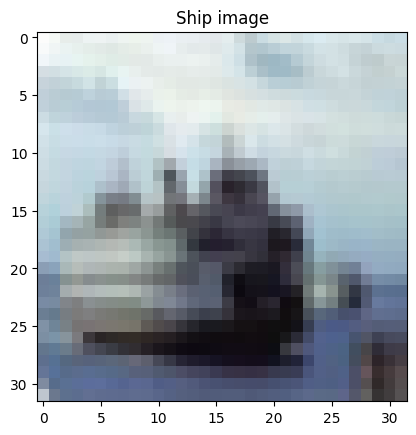

In [39]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tf_keras_vis import utils
# Indexes of categories for our model
classes = encode_X.inverse_transform(np.arange(10))
classes
# array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
#        'horse', 'ship', 'truck'], dtype=object)
# Fetching the ship image
ship_img = keras.utils.load_img('cifar10/'+str(test_idx[6])+'.png') # can use Image.open() also.
plt.imshow(ship_img)
plt.title('Ship image')
plt.show()

### Since we know that given target is a ship, now let us predict the probability of the classes based on our model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


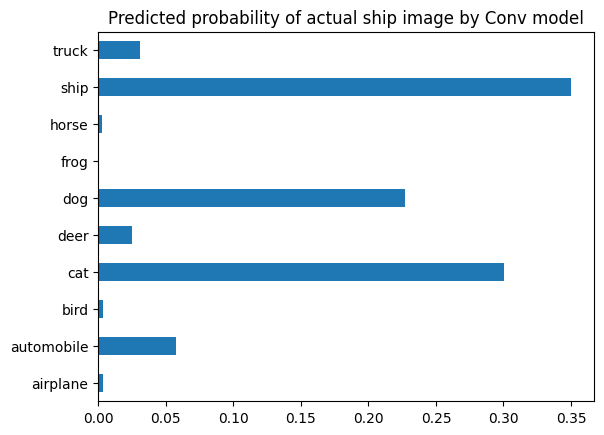

In [40]:
# Predicting the probability for each of the class
ship_prob = model.predict(X_test[6:7]).ravel().copy()
pd.Series(ship_prob, index=classes).plot.barh()
plt.title('Predicted probability of actual ship image by Conv model')
plt.show()

### To visualize activation over final dense layer outputs, we need to switch the softmax activation to linear since the gradient of the output node will depend on all the other node activations.

In [61]:
# Get layer by name directly
layer = model.get_layer('pred_layer')
layer.activation = keras.activations.linear
model_modifier = ReplaceToLinear()

### 1. Saliency map
#### Saliency maps clarify which part does our model focuses on to get a prediction.

In [ ]:
plt.figure(figsize=(12,6))
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
    grads = visualize_saliency(model, layer_idx, filter_indices=i, seed_input=ship_img, backprop_modifier='guided')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    plt.title('p=' + str(np.round(ship_prob[i], 4)))
    plt.imshow(grads, cmap='jet')
plt.show()

AttributeError: 'Sequential' object has no attribute 'output_names'

### 2. Class activation maps or Grad-cam

In [ ]:
plt.figure(figsize=(12,6))
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
    cam_grads = visualize_cam(model, layer_idx, filter_indices=i, seed_input=ship_img, backprop_modifier='guided',
                             penultimate_layer_idx=utils.find_layer_idx(model, 'BN_2'))# batch_normalization_14
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    plt.title('p=' + str(np.round(ship_prob[i], 4)))
    plt.imshow(overlay(cam_grads, ship_img, alpha=0.3))
plt.show()

## CNN Hyperparamenter Tuning

### Case 1 - Stride: 2 and Filter size: (3x3)

In [ ]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_stride_2.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
from mlxtend.evaluate import scoring
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.

### Case 2 - Stride: 3 and Filter size: (3x3)

In [ ]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=3, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=3, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_stride_3.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.

### Case 3 - Stride 1 and Filter size: (2x2)

In [ ]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_filter_2.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.

### Case 4 - Stride: 1 and Filter size: (4x4)

In [ ]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_filter_4.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.

## Conclusion
### Here's the table which compares the performance of the above four models with the basic model we built earlier:
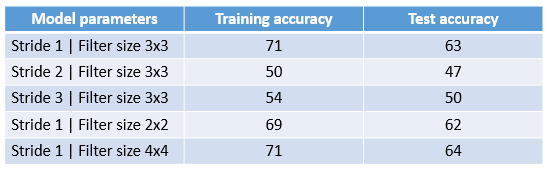


### As you can observe from the above table, just by varying two hyperparameters the accuracy changes dramatically. Even with very large filter size and stride rate, the model may not be able to learn small spatial features.